In [1]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
# dataset_dir = './ohara2017_LeemV1_fixed_concentrations_Mid-myocardial'
# sys.path.append( dataset_dir )
# from agetdata import get_currents_with_constant_dt

In [14]:
result_dir = "./Results"
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    else:
        print("The folder already exsits")
except OSError:
    print(f"Error: {result_dir} has not been created.")

The folder already exsits


In [15]:
import vc_protocols
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()
VC_protocol = vc_protocols.leemV1_CiPA()

vhold = -80 # VC_protocol.steps[0].voltage

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1320 ms


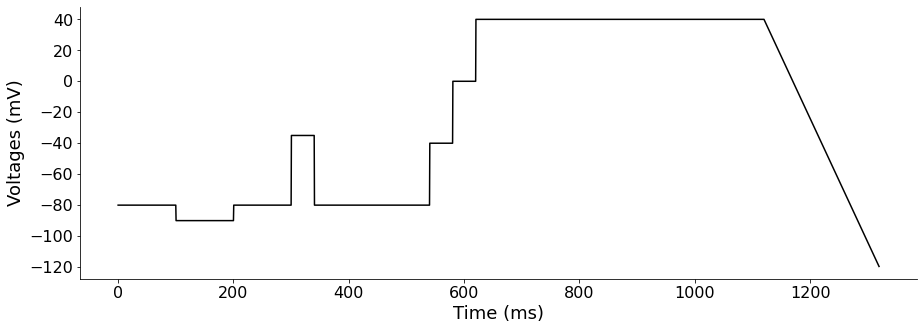

In [16]:
times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 0.5) 
VC_protocol.plot_voltage_clamp_protocol(times)

In [17]:
end_time = VC_protocol.get_voltage_change_endpoints()[-1]
bcl = 1000
duration = 0.5
offset = 20
window = 10
step_size = 5

cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL_total', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa']

t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 10000)  

In [18]:
start_time = time.time()

model, p, s = myokit.load("../../../mmt-model-files/ohara-cipa-v1-2017_JK-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  
f = 1.5
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0199575 * f,  # 0.0075 * 2.661 * f,  
    'ito.gto' : 0.08 * f, # 0.02 * 4 * f,
    'ical.PCa' : 0.00025175 * f, # 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 0.06056109090909093 * f,  #  4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0089012 * f, # 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.42117192000000003 * f, # 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
    
    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 1,
    'ical.g_adj' : 1,
    'ikr.g_adj' : 1,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1,
    'inaca.g_adj' : 1,
    'inak.g_adj' : 1,
    'ikb.g_adj' : 1,
    'inab.g_adj' : 1,
    'icab.g_adj' : 1,
    'ipca.g_adj' : 1, 
}
sim.set_simulation_params(params)
y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol1["I_total"] = d['membrane.i_ion']
# sol1["window"] = get_currents_with_constant_dt([ d['engine.time'], d['membrane.i_ion'] ], window=window, step_size=step_size)
sol1["INa"] = d['ina.INa']
sol1["INaL"] = d['inal.INaL']
sol1["Ito"] = d['ito.Ito']
sol1["ICaL"] = d['ical.ICaL_total']
sol1["IKr"] = d['ikr.IKr']
sol1["IKs"] = d['iks.IKs']
sol1["IK1"] = d['ik1.IK1']

tr = mod_trace.Trace(VC_protocol,
                     cell_params=None,
                     t=times1,
                     y=sol1["Voltage"],  # simulator.model.V,
                     command_voltages=sol1["Voltage"],
                     current_response_info=sim.current_response_info,
                     default_unit=None)   
max_contributions1 = tr.current_response_info.get_max_current_contributions(time=times1,
                                                                           window=window,
                                                                           step_size=step_size)

print("--- %s seconds ---"%(time.time()-start_time))

--- 4.14245080947876 seconds ---


In [19]:
start_time = time.time()

model, p, s = myokit.load("../../../mmt-model-files/ohara-cipa-v1-2017_fixedconc-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  
f = 1.5
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0199575 * f,  # 0.0075 * 2.661 * f,  
    'ito.gto' : 0.08 * f, # 0.02 * 4 * f,
    'ical.PCa' : 0.00025175 * f, # 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 0.06056109090909093 * f,  #  4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0089012 * f, # 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.42117192000000003 * f, # 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
    
    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 1,
    'ical.g_adj' : 1,
    'ikr.g_adj' : 1,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1,
    'inaca.g_adj' : 1,
    'inak.g_adj' : 1,
    'ikb.g_adj' : 1,
    'inab.g_adj' : 1,
    'icab.g_adj' : 1,
    'ipca.g_adj' : 1, 
}
sim.set_simulation_params(params)
y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol2 = {}
times2 = d['engine.time']
sol2["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol2["I_total"] = d['membrane.i_ion']
# sol2["window"] = get_currents_with_constant_dt([ d['engine.time'], d['membrane.i_ion'] ], window=window, step_size=step_size)
sol2["INa"] = d['ina.INa']
sol2["INaL"] = d['inal.INaL']
sol2["Ito"] = d['ito.Ito']
sol2["ICaL"] = d['ical.ICaL_total']
sol2["IKr"] = d['ikr.IKr']
sol2["IKs"] = d['iks.IKs']
sol2["IK1"] = d['ik1.IK1']

tr = mod_trace.Trace(VC_protocol,
                     cell_params=None,
                     t=times1,
                     y=sol1["Voltage"],  # simulator.model.V,
                     command_voltages=sol1["Voltage"],
                     current_response_info=sim.current_response_info,
                     default_unit=None)   
max_contributions2 = tr.current_response_info.get_max_current_contributions(time=times2,
                                                                            window=window,
                                                                            step_size=step_size)

contribution2 = tr.current_response_info.get_current_contributions( time=times2, window=window, step_size=step_size)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.929171562194824 seconds ---


In [20]:
max_contributions1

,Current,Contribution,Time Start,Time End
0,i_ion,0.000000,0.0,10.0
1,INa,0.396722,540.0,550.0
2,INaL,0.334431,565.0,575.0
3,Ito,0.238398,625.0,635.0
4,ICaL_total,0.474377,585.0,595.0
5,IKr,0.363777,1200.0,1210.0
6,IKs,0.211091,1115.0,1125.0
7,IK1,0.495084,1310.0,1320.0
8,INaCa,0.062266,1275.0,1285.0
9,INaCa_ss,0.105164,320.0,330.0


In [21]:
max_contributions2

,Current,Contribution,Time Start,Time End
0,i_ion,0.000000,0.0,10.0
1,INa,0.399851,540.0,550.0
2,INaL,0.414918,325.0,335.0
3,Ito,0.184903,625.0,635.0
4,ICaL_total,0.496033,1145.0,1155.0
5,IKr,0.367760,1200.0,1210.0
6,IKs,0.208376,1115.0,1125.0
7,IK1,0.496402,1310.0,1320.0
8,INaCa,0.021672,1275.0,1285.0
9,INaCa_ss,0.005265,1275.0,1285.0


In [22]:
contribution2

,Time Start,Time End,Time Mid,i_ion,INa,INaL,Ito,ICaL_total,IKr,IKs,IK1,INaCa,INaCa_ss,INaK,IKb,INab,ICab,IpCa
0,0,10,5.0,0.0,2.171908e-03,2.026468e-04,0.000300,8.322176e-07,0.000101,1.125824e-07,0.486227,0.005450,0.001325,0.013333,2.550606e-05,0.003005,0.003354,1.384193e-05
1,5,15,10.0,0.0,2.171908e-03,2.026483e-04,0.000300,8.322175e-07,0.000101,1.122991e-07,0.486227,0.005450,0.001325,0.013333,2.550605e-05,0.003005,0.003354,1.384193e-05
2,10,20,15.0,0.0,2.171909e-03,2.026496e-04,0.000300,8.322173e-07,0.000101,1.120382e-07,0.486227,0.005450,0.001325,0.013333,2.550605e-05,0.003005,0.003354,1.384193e-05
3,15,25,20.0,0.0,2.171909e-03,2.026510e-04,0.000300,8.322172e-07,0.000101,1.117780e-07,0.486227,0.005450,0.001325,0.013333,2.550605e-05,0.003005,0.003354,1.384193e-05
4,20,30,25.0,0.0,2.171909e-03,2.026523e-04,0.000300,8.322171e-07,0.000101,1.115184e-07,0.486227,0.005450,0.001325,0.013333,2.550605e-05,0.003005,0.003354,1.384193e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,1290,1300,1295.0,0.0,5.546590e-06,4.167735e-07,0.000024,2.580328e-09,0.009676,1.075794e-03,0.486040,0.001174,0.000285,0.002609,2.833831e-06,0.000801,0.000915,3.048438e-06
259,1295,1305,1300.0,0.0,1.281334e-06,1.553453e-07,0.000016,6.417197e-10,0.007124,6.141848e-04,0.490115,0.000767,0.000186,0.001666,2.036832e-06,0.000546,0.000627,2.000402e-06
260,1300,1310,1305.0,0.0,3.452942e-07,6.620051e-08,0.000012,1.928531e-10,0.005313,3.753782e-04,0.492686,0.000569,0.000138,0.001208,1.533400e-06,0.000421,0.000484,1.488161e-06
261,1305,1315,1310.0,0.0,9.230006e-08,2.862266e-08,0.000008,5.945663e-11,0.003874,2.263335e-04,0.494596,0.000446,0.000108,0.000927,1.170385e-06,0.000344,0.000396,1.173093e-06


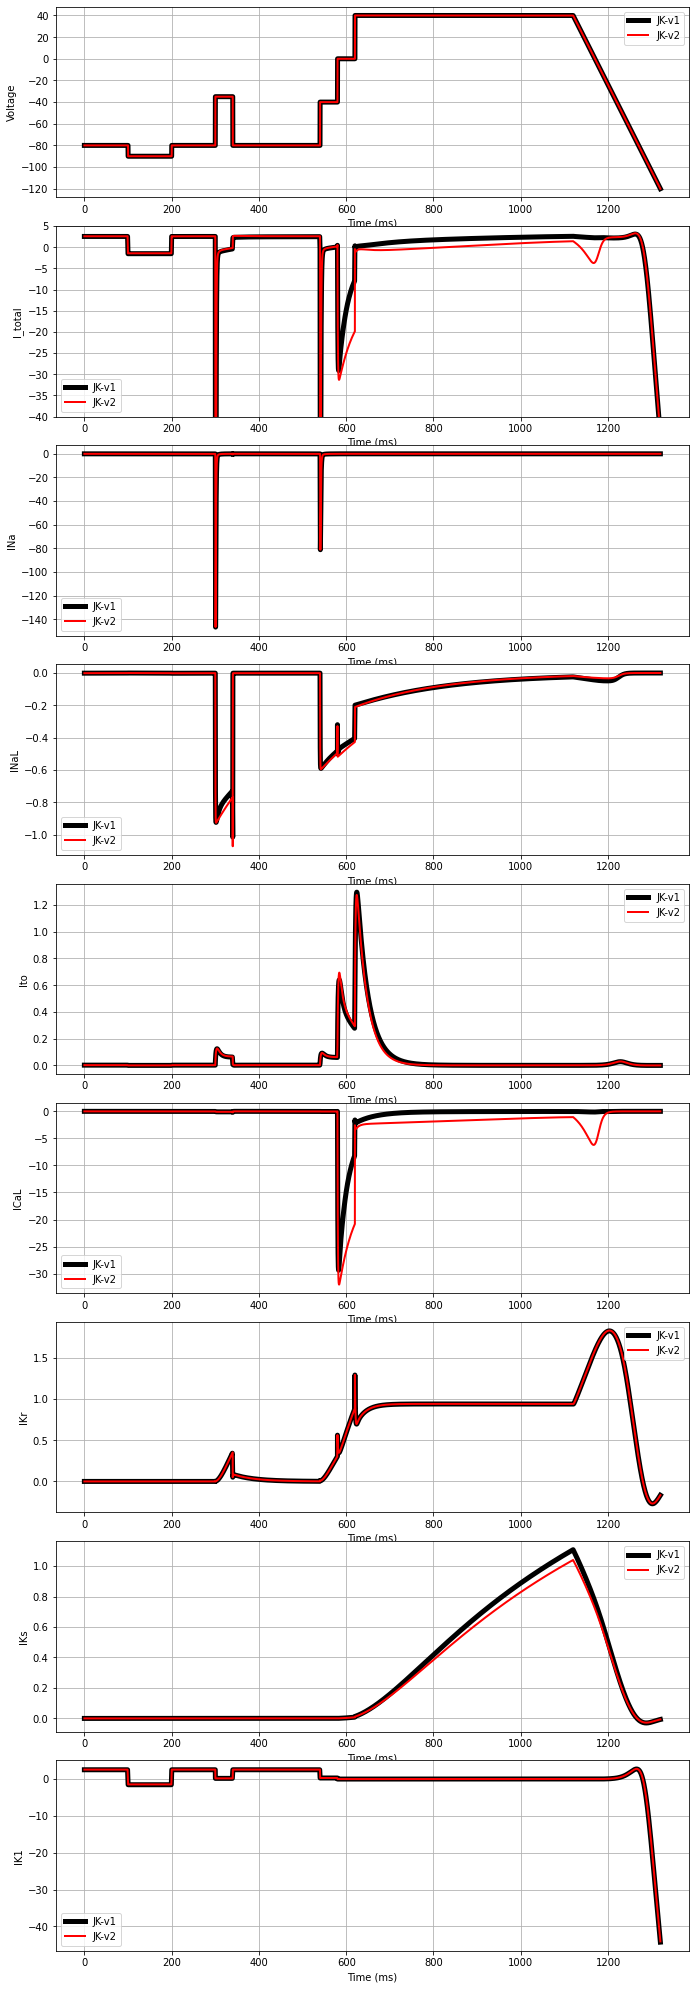

In [23]:
'''
Plot
'''
# current_name = 'IKr'
fig, ax = plt.subplots(len(sol1),1, figsize=(10,30))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol1.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])    
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times1, values, label='JK-v1', color='k', linewidth=5)     
    ax[i].plot( times2, sol2[name], label='JK-v2', color='r', linewidth=2)    
    ax[i].legend()
    ax[i].grid()
    
    # if i!=0 and i!=1:
    #     contribution = max_contributions1[max_contributions1["Current"]==name]['Contribution'].values[0]
    #     start = max_contributions1[max_contributions1["Current"]==name]['Time Start'].values[0]
    #     end = max_contributions1[max_contributions1["Current"]==name]['Time End'].values[0]         
    #     ax[i].axvspan(start, end, color='g', alpha=0.3)  
    
ax[1].set_ylim(-40, 5) 

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join(result_dir, f"fixed_concentration-vs-unfixed_concentration.jpg"), dpi=100)